In [1]:
!pip install torchview

In [2]:
import torch  # PyTorch library for tensor computation and deep neural networks
import numpy as np  # NumPy library for numerical operations
from torchvision import datasets  # PyTorch module for access to popular datasets, model architectures, and image transformations for computer vision
import torchvision.transforms as transforms  # PyTorch module for common image transformations
from torch.utils.data.sampler import SubsetRandomSampler  # Sampler that restricts data loading to a subset of the dataset
import matplotlib.pyplot as plt  # Matplotlib library for creating static, animated, and interactive visualizations in Python
import torchview  # Library for visualizing PyTorch models and metrics
import torch.optim as optim  # PyTorch module for optimization algorithms
import torch.nn as nn  # PyTorch module for neural network operations
import torch.nn.functional as F  # PyTorch module for functional interface
from torchview import draw_graph  # Function from torchview for drawing computational graph of PyTorch models



In [3]:

train_on_gpu = torch.cuda.is_available() # Check if CUDA is available

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:

# number of subprocesses to use for data loading
num_workers = 0
# how many sampls per batch to load
batch_size = 64
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform) # define the training and test datasets
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)


# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers) # define the training and test loaders
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,  num_workers=num_workers, shuffle=False)

# specify the image classes
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
           'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

100%|██████████| 170498071/170498071 [00:03<00:00, 48386703.85it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


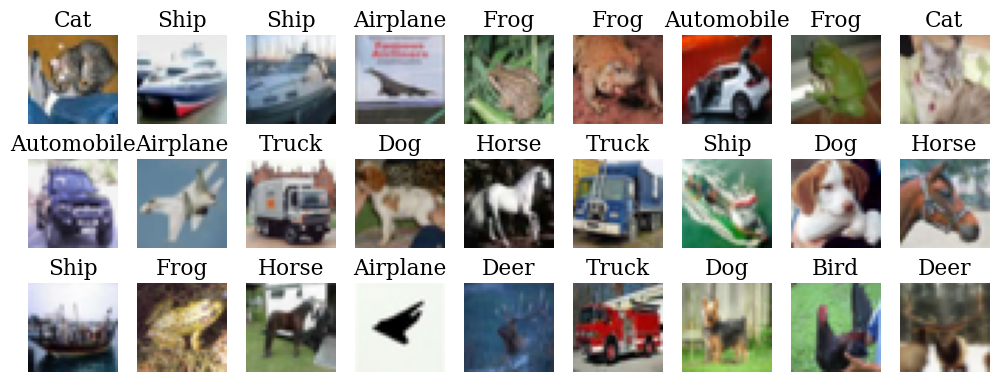

In [5]:
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"]})

plt.rcParams['font.size'] = 13
plt.rcParams['legend.framealpha'] = 0.3

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 4))
# display 20 images
for idx in np.arange(27):
    ax = fig.add_subplot(3, 9, idx+1, xticks=[], yticks=[])
    imshow(example_data[idx].detach().numpy())
    ax.set_title(classes[example_targets[idx]])
plt.tight_layout()
plt.savefig("cifar10.pdf")
plt.show()

In [6]:
class CNN(nn.Module):
  def __init__(self): # Define the layers of the network
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5) # 3 input channels, 6 output channels, 5x5 kernel
    self.pool = nn.MaxPool2d(2, 2) # 2x2 kernel
    self.conv2 = nn.Conv2d(6, 16, 5) # 6 input channels, 16 output channels, 5x5 kernel
    self.fc1 = nn.Linear(16 * 5 * 5, 120) # 16x5x5 input features, 120 output features
    self.fc2 = nn.Linear(120, 84) # 120 input features, 84 output features
    self.fc3 = nn.Linear(84, 10) # 84 input features, 10 output features

  def forward(self, x): # Define the forward pass
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x


In [7]:
model = CNN() # Create the model
model = model.cuda() # Move the model to GPU

In [8]:
# specify loss function
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=.01)

In [9]:
# number of epochs to train the model
n_epochs = [*range(1, 50)]
#List to store loss to visualize
train_losslist = []
valid_loss_min = np.Inf # track change in validation loss

train_losses = []
train_counter = []
test_losses = []
acc_eval = []
test_counter = [i*len(train_loader.dataset) for i in n_epochs]

for epoch in n_epochs:

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        if batch_idx%(781//5)==0:
            train_losses.append(loss.item())
            train_counter.append(
                    (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

    ######################
    # validate the model #
    ######################
    model.eval()
    correct=0
    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum().item()

    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)
    acc_eval.append(correct/len(test_loader.dataset)*100)
    train_losslist.append(train_loss)
    test_losses.append(valid_loss)
    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar_small_cnn.pt')
        valid_loss_min = valid_loss

torch.save(model.state_dict(), 'model_cifar_small_cnn.pt')
torch.save({"test_loss":(test_counter, test_losses),
            "train_loss":(train_counter, train_losses),
           "acc_eval": acc_eval}, 'model_cifar_small_cnn_res.pt')

Epoch: 1 	Training Loss: 2.302416 	Validation Loss: 2.299102
Validation loss decreased (inf --> 2.299102).  Saving model ...
Epoch: 2 	Training Loss: 2.272520 	Validation Loss: 2.200749
Validation loss decreased (2.299102 --> 2.200749).  Saving model ...
Epoch: 3 	Training Loss: 2.129675 	Validation Loss: 2.044684
Validation loss decreased (2.200749 --> 2.044684).  Saving model ...
Epoch: 4 	Training Loss: 1.968445 	Validation Loss: 1.927222
Validation loss decreased (2.044684 --> 1.927222).  Saving model ...
Epoch: 5 	Training Loss: 1.845315 	Validation Loss: 1.838090
Validation loss decreased (1.927222 --> 1.838090).  Saving model ...
Epoch: 6 	Training Loss: 1.699325 	Validation Loss: 1.707887
Validation loss decreased (1.838090 --> 1.707887).  Saving model ...
Epoch: 7 	Training Loss: 1.595133 	Validation Loss: 1.627796
Validation loss decreased (1.707887 --> 1.627796).  Saving model ...
Epoch: 8 	Training Loss: 1.528915 	Validation Loss: 1.575440
Validation loss decreased (1.62779

KeyboardInterrupt: 

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters()) # Count the number of parameters:w
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

In [ ]:
plt.rcParams['text.usetex'] = True
plt.clf()
plt.figure(figsize=(12, 8))
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"]})

plt.rcParams['font.size'] = 15
plt.rcParams['legend.framealpha'] = 0.3

plt.plot(train_counter, train_losses, color='#08457E')
plt.scatter(test_counter, test_losses, color='#F44336',zorder=+100)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlim([0, max(train_counter)])
plt.ylim([0, 1.1*max(train_losses)])
plt.xlabel('Number of Examples Seen by the model')
plt.ylabel('Cross-Entropy')
plt.annotate("", xy=(min(train_counter)-0.3, max(train_losses)*1.15), xytext=(min(train_counter)-0.3,-0.05),
        arrowprops=dict(arrowstyle="->"),annotation_clip=False, zorder=-100)
plt.annotate("", xy=(max(train_counter)+10000, -0.0), xytext=(min(train_counter)-1000,-0.0),
        arrowprops=dict(arrowstyle="->"),annotation_clip=False, zorder=-100)
plt.savefig('figures/smallconvcifar_res.pdf',bbox_inches='tight')

In [ ]:
plt.rcParams['text.usetex'] = True
plt.clf()
plt.figure(figsize=(12, 8))
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"]})

plt.rcParams['font.size'] = 15
plt.rcParams['legend.framealpha'] = 0.3

plt.plot(n_epochs, acc_eval, color='#08457E')
plt.xlim([0, max(n_epochs)])
plt.ylim([0, 100])
plt.xlabel('Epochs')
plt.ylabel('Accuracy (\%)')
plt.annotate("", xy=( max(n_epochs)*1.1,0), xytext=(-0.5,0),
        arrowprops=dict(arrowstyle="->"),annotation_clip=False, zorder=-100)
plt.annotate("", xy=(0, 105.0), xytext=(0,0),
        arrowprops=dict(arrowstyle="->"),annotation_clip=False, zorder=-100)
plt.savefig('smallconvcifar_acc.pdf',bbox_inches='tight')

In [ ]:

batch_size = 64
# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(model,
                         input_size=(batch_size, 3, 32, 32),
                         device='cuda',
                         graph_dir='TB',
                         filename='convcifar',
                        save_graph=True)

model_graph.visual_graph.render(format='pdf')

In [ ]:
class FC(nn.Module):
  def __init__(self):
    super(FC, self).__init__()
    self.fc1 = nn.Linear(3*32*32, 1024)
    self.fc2 = nn.Linear(1024, 256)
    self.fc3 = nn.Linear(256, 64)
    self.fc4 = nn.Linear(64, 10)
  def forward(self, x):
    x = x.view(-1, 3*32*32)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [ ]:
model = FC()
model = model.cuda()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
optimizer = optim.SGD(model.parameters(), lr=.001)

In [ ]:
# number of epochs to train the model
n_epochs = [*range(1, 50)]
#List to store loss to visualize
train_losslist = []
valid_loss_min = np.Inf # track change in validation loss

train_losses = []
train_counter = []
test_losses = []
acc_eval = []
test_counter = [i*len(train_loader.dataset) for i in n_epochs]

for epoch in n_epochs:

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        if batch_idx%(781//5)==0:
            train_losses.append(loss.item())
            train_counter.append(
                    (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

    ######################
    # validate the model #
    ######################
    model.eval()
    correct=0
    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum().item()

    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)
    acc_eval.append(correct/len(test_loader.dataset)*100)
    train_losslist.append(train_loss)
    test_losses.append(valid_loss)
    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar_small_dense.pt')
        valid_loss_min = valid_loss

torch.save(model.state_dict(), 'model_cifar_small_dense.pt')
torch.save({"test_loss":(test_counter, test_losses),
            "train_loss":(train_counter, train_losses),
           "acc_eval": acc_eval}, 'model_cifar_small_dense_res.pt')

In [ ]:
plt.rcParams['text.usetex'] = True
plt.clf()
plt.figure(figsize=(12, 8))
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"]})

plt.rcParams['font.size'] = 15
plt.rcParams['legend.framealpha'] = 0.3

plt.plot(train_counter, train_losses, color='#08457E')
plt.scatter(test_counter, test_losses, color='#F44336',zorder=+100)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlim([0, max(train_counter)])
plt.ylim([0, 1.1*max(train_losses)])
plt.xlabel('Number of Examples Seen by the model')
plt.ylabel('Cross-Entropy')
plt.annotate("", xy=(min(train_counter)-0.3, max(train_losses)*1.15), xytext=(min(train_counter)-0.3,-0.05),
        arrowprops=dict(arrowstyle="->"),annotation_clip=False, zorder=-100)
plt.annotate("", xy=(max(train_counter)+10000, -0.0), xytext=(min(train_counter)-1000,-0.0),
        arrowprops=dict(arrowstyle="->"),annotation_clip=False, zorder=-100)
plt.savefig('smalldensecifar_res.pdf',bbox_inches='tight')

In [ ]:
batch_size = 64
# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(model,
                         input_size=(batch_size, 3, 32, 32),
                         device='cuda',
                         graph_dir='TB',
                         filename='figures/densecifar',
                        save_graph=True)

model_graph.visual_graph.render(format='pdf')

In [ ]:
plt.rcParams['text.usetex'] = True
plt.clf()
plt.figure(figsize=(12, 8))
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"]})

plt.rcParams['font.size'] = 15
plt.rcParams['legend.framealpha'] = 0.3

plt.plot(n_epochs, acc_eval, color='#08457E')
plt.xlim([0, max(n_epochs)])
plt.ylim([0, 100])
plt.xlabel('Epochs')
plt.ylabel('Accuracy (\%)')
plt.annotate("", xy=( max(n_epochs)*1.1,0), xytext=(-0.5,0),
        arrowprops=dict(arrowstyle="->"),annotation_clip=False, zorder=-100)
plt.annotate("", xy=(0, 105.0), xytext=(0,0),
        arrowprops=dict(arrowstyle="->"),annotation_clip=False, zorder=-100)
plt.savefig('smalldensecifar_acc.pdf',bbox_inches='tight')

In [ ]:
class CNN(nn.Module):


    def __init__(self):

        super(CNN, self).__init__()
        list_of_ops = [[nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)] for _ in range(10) ]
        self.conv_layer1 = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv_layer2 = nn.Sequential(

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05))
        self.conv_layer3 = nn.Sequential(

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )

    def conv_out(self, x, c):
        return  self.conv_layer1(x)[:, c, :, :]
    def forward(self, x):
        """Perform forward."""

        # conv layers
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)

        # flatten
        x = x.view(x.size(0), -1)

        # fc layer
        x = self.fc_layer(x)
        return x

In [ ]:
model = CNN()
model = model.cuda()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
optimizer = optim.SGD(model.parameters(), lr=.001)

In [ ]:
# number of epochs to train the model
n_epochs = [*range(1, 50)]
#List to store loss to visualize
train_losslist = []
valid_loss_min = np.Inf # track change in validation loss

train_losses = []
train_counter = []
test_losses = []
acc_eval = []
test_counter = [i*len(train_loader.dataset) for i in n_epochs]

for epoch in n_epochs:

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        if batch_idx%(781//5)==0:
            train_losses.append(loss.item())
            train_counter.append(
                    (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

    ######################
    # validate the model #
    ######################
    model.eval()
    correct=0
    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum().item()

    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)
    acc_eval.append(correct/len(test_loader.dataset)*100)
    train_losslist.append(train_loss)
    test_losses.append(valid_loss)
    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar_large_conv.pt')
        valid_loss_min = valid_loss

torch.save(model.state_dict(), 'model_cifar_large_conv_ckpt.pt')
torch.save({"test_loss":(test_counter, test_losses),
            "train_loss":(train_counter, train_losses),
           "acc_eval": acc_eval}, 'model_cifar_large_conv_res.pt')

In [ ]:
plt.rcParams['text.usetex'] = True
plt.clf()
plt.figure(figsize=(12, 8))
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"]})

plt.rcParams['font.size'] = 15
plt.rcParams['legend.framealpha'] = 0.3

plt.plot(train_counter, train_losses, color='#08457E')
plt.scatter(test_counter, test_losses, color='#F44336',zorder=+100)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlim([0, max(train_counter)])
plt.ylim([0, 1.1*max(train_losses)])
plt.xlabel('Number of Examples Seen by the model')
plt.ylabel('Cross-Entropy')
plt.annotate("", xy=(min(train_counter)-0.3, max(train_losses)*1.15), xytext=(min(train_counter)-0.3,-0.05),
        arrowprops=dict(arrowstyle="->"),annotation_clip=False, zorder=-100)
plt.annotate("", xy=(max(train_counter)+10000, -0.0), xytext=(min(train_counter)-1000,-0.0),
        arrowprops=dict(arrowstyle="->"),annotation_clip=False, zorder=-100)
plt.savefig('largeconvcifar_res.pdf',bbox_inches='tight')

In [ ]:
plt.rcParams['text.usetex'] = True
plt.clf()
plt.figure(figsize=(12, 8))
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"]})

plt.rcParams['font.size'] = 15
plt.rcParams['legend.framealpha'] = 0.3

plt.plot(n_epochs, acc_eval, color='#08457E')
plt.xlim([0, max(n_epochs)])
plt.ylim([0, 100])
plt.xlabel('Epochs')
plt.ylabel('Accuracy (\%)')
plt.annotate("", xy=( max(n_epochs)*1.1,0), xytext=(-0.5,0),
        arrowprops=dict(arrowstyle="->"),annotation_clip=False, zorder=-100)
plt.annotate("", xy=(0, 105.0), xytext=(0,0),
        arrowprops=dict(arrowstyle="->"),annotation_clip=False, zorder=-100)
plt.savefig('largeconvcifar_acc.pdf',bbox_inches='tight')

In [ ]:

batch_size = 64
# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(model,
                         input_size=(batch_size, 3, 32, 32),
                         device='cuda',
                         graph_dir='TB',
                         filename='largeconvcifar',
                        save_graph=True)

model_graph.visual_graph.render(format='pdf')

In [ ]:

color = ['#08457E', "darkviolet", "dodgerblue"]
plt.rcParams['text.usetex'] = True
plt.clf()
plt.figure(figsize=(12, 8))
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"]})

plt.rcParams['font.size'] = 15
plt.rcParams['legend.framealpha'] = 0.3

plt.xlim([0, max(n_epochs)])
plt.ylim([0, 100])
plt.xlabel('Epochs')
plt.ylabel('Accuracy (\%)')
plt.annotate("", xy=( max(n_epochs)*1.1,0), xytext=(-0.5,0),
        arrowprops=dict(arrowstyle="->"),annotation_clip=False, zorder=-100)
plt.annotate("", xy=(0, 105.0), xytext=(0,0),
        arrowprops=dict(arrowstyle="->"),annotation_clip=False, zorder=-100)

for k, state in enumerate(['model_cifar_large_conv_res.pt','model_cifar_small_dense_res.pt', 'model_cifar_small_cnn_res.pt']):
    res = torch.load(state)
    plt.plot(res['acc_eval'],  c=color[k])
plt.legend(["CNN : $5.8$M", "FC : $3.4$M", "CNN: $62$k" ])
plt.savefig('conv_res.pdf')